# Kuzushiji-49: An Introduction to CNNs

### Introduction

Here we will explore the application of Convolutional Neural Networks, a type of deep learning (or artificial neural network) to the problem of image classification using the Kuzushiji-MNIST dataset. 

*Classification* refers to predicting the "class label" for an observation in a dataset or a new observation, given a set of data with accompanying labels. In machine learning parlance, classification is a type of *supervised learning*. More generally speaking, the machine learning task here is to train a model to correctly identify the category of an observation. In the case of computer vision problems such as the one we will tackle here, this corresponds to identifying to which category an image most likely belongs, given previous examples.  

### The Data

The "Hello World" of computer vision is the MNIST dataset, which is composed of standardized images of digits 0-9. The dataset we will be working with here, the [Kuzushiji-49](http://codh.rois.ac.jp/kmnist/index.html.en) is a similar but more complex task, where the goal is to train a model to identify one of 49 handwritten Japanese characters in the [hiragana](https://en.wikipedia.org/wiki/Hiragana) writing system.

First we will need to download the data. There is a downloader utility provided in the official [github repo](https://github.com/rois-codh/kmnist) you can use, however, I will just grab the specific files needed for the dataset we'll be working with here.

We can do this on our local machine by running the following terminal commands (`curl` does not play nicely with Jupyer, unfortunately):

- Training data: `curl http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-imgs.npz -O data/k49-train-imgs.npz`
- Training labels: `curl http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-labels.npz -O data/k49-train-labels.npz`
- Testing data: `curl http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-imgs.npz -O data/k49-test-imgs.npz`
- Testing labels: `curl http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-labels.npz -O data/k49-test-labels.npz` 

There is also a classmap file, to map the integer class labels to hiragan names:
- `curl http://codh.rois.ac.jp/kmnist/dataset/k49/k49_classmap.csv -O data/k49_classmap.csv`

To load and visualize the data, we will need the fundamental pieces of the data science stack in python, [numpy](https://numpy.org/) for load and working with the image arrays, [pandas](https://pandas.pydata.org/) to make wrangling the data easier, and [matplotlib](https://matplotlib.org/) for visualization. We import these here:

In [1]:
# Import the holy trinity of data science
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Training Data

First, we can load the image data and take a look at the pictures which comprise the Kuzushiji-49. These are stored in compressed `.npz` format, and for this dataset contain a single 3-D numpy array of all the images, `arr_0`:

In [2]:
# Load the data from numpy format
train_img = np.load('data/k49-train-imgs.npz')

# Check the shape of the stored array
train_img['arr_0'].shape

(232365, 28, 28)

As we can see, the training set has 232,365 images, of size 28x28 in monochrome (as there is third dimension for red, green, blue color channels). This is the same format as the MNIST dataset.

Now let's pull the data out into our `X_train` array:

In [3]:
# Just the data please
X_train = train_img['arr_0']

Each single image (row) is a 28x28 numpy array with values between 0 and 255:

In [27]:
# Look at the shape of a single image
X_train[4,:,:].shape

(28, 28)

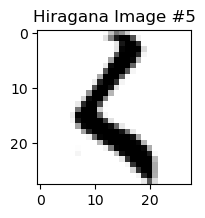

In [30]:
# Visualize
plt.figure(figsize=(2,2))
plt.title('Hiragana Image #5')
plt.imshow(X_train[4, :, :], cmap='gray_r')
plt.show()

We can see that image 5 (at index 4) is that for [the hiragana for 'ku'](https://en.wikipedia.org/wiki/Ku_(kana)). Now we can take a look at some examples of the data:

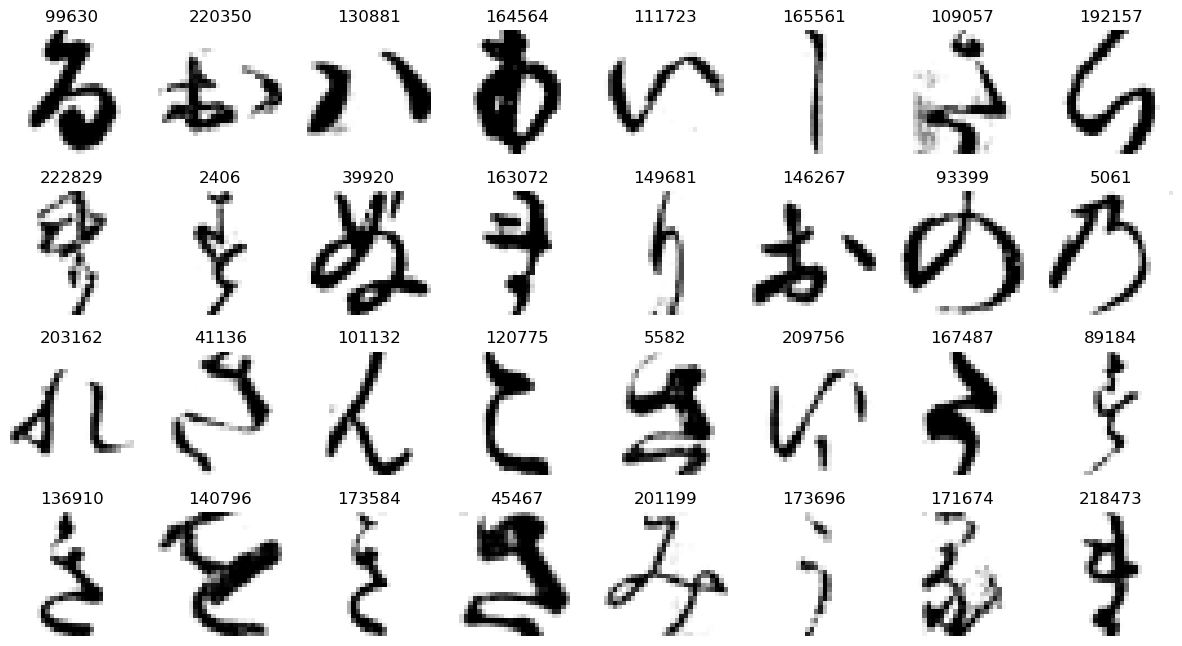

In [33]:
# Create a random array of indices between 0 and the number of images of size 32
rand_ind = np.random.randint(0, X_train.shape[0], 32)

# Create subplot grid
plt.subplots(4, 8, figsize=(15, 8))

# Iterate and show each randomly selected image
for plot_index, img_index in enumerate(rand_ind):
    plt.subplot(4, 8, plot_index + 1)
    plt.title(img_index)
    plt.axis('off') # hide axes
    plt.imshow(X_train[img_index, :, :], cmap='gray_r')

plt.show()

We also have the class labels associated with each image, which show which hiragana character each image is supposed to be. These are contained in a separate file, which we load the same way:

In [34]:
train_labels = np.load('data/k49-train-labels.npz')

Let's take a look at how the class labels are structured:

In [41]:
# Check size
train_labels['arr_0'].shape

(232365,)

In [42]:
train_labels['arr_0']

array([30, 19, 20, ..., 10, 39, 30], dtype=uint8)

We can see that there is a distinct class label for each row in the training data, as the dimensionalities match - 232,365 class labels. We can also see that each class label is just a simple integer. Let's pull out the training labels into a pandas series, for convenience: 

In [51]:
# Pull out the class labels into a pandas series
y_train = pd.Series(train_labels['arr_0'])

# Check
y_train.head()

0    30
1    19
2    20
3    30
4     7
dtype: uint8

We will also load the class map data - this is to servce as our lookup table of the integer classes to the hiragana character names. This file is a csv and so we load directly with pandas using `.read_csv`:

In [52]:
# Load the class map
classmap = pd.read_csv('data/k49_classmap.csv')

# Take a look
classmap.head()

,index,codepoint,char
0,0,U+3042,あ
1,1,U+3044,い
2,2,U+3046,う
3,3,U+3048,え
4,4,U+304A,お


Now let's see if there are equal numbers of images (or nearly so) for our training data, or in the machine learning practitioner's parlance, if we have a *balanced* classification problem - technically speaking, what is the *support* for each class?

We'll replace the numeric indices with the characters here using the classmap. Unfortunately, default fonts do not allow rendering of Japanese characters, especially in matplotlib, so we will need to specify a different font.

There are some good resources on this below if you'd like to explore further on your own:
- [Japanese NLP Scripts by olsgaard](https://github.com/olsgaard/Japanese_nlp_scripts)
- [Displaying CJK Characters in Matplotlib Plots](https://albertauyeung.github.io/2020/03/15/matplotlib-cjk-fonts.html)

In [91]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'sans-serif']

In [108]:
np.unique(y_train.value_counts().values, return_counts=True)

(array([ 392,  417,  777, 1598, 1718, 1993, 2063, 2139, 2397, 2451, 2565,
        3060, 3394, 3523, 3867, 4165, 4714, 5132, 6000], dtype=int64),
 array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1, 31], dtype=int64))

We can see out of the 49 hiragana characters, the vast majority have an equal number of observations with 6000 observations - 31/49 or ~63%. For each of these, this represents about 2.6% of the dataset:

In [140]:
6000/X_train.shape[0]*100.0

2.5821444709831516

The remainder have less, let's look at only these: 

In [141]:
# Find the observation count per character and change the index to the characters from int class label
char_counts = y_train.map(classmap['char']).value_counts()

# Create a bar plot for only those with less than 6000 observations
filtered = char_counts[char_counts < 6000].sort_values()

filtered/X_train.shape[0]*100.0

ゑ    0.168700
ゐ    0.179459
え    0.334388
ゆ    0.687711
む    0.739354
ほ    0.857702
ぬ    0.887827
ろ    0.920535
わ    1.031567
ね    1.054806
ち    1.103867
み    1.316894
め    1.460633
ゝ    1.516149
そ    1.664192
せ    1.792439
け    2.028705
ひ    2.208594
dtype: float64

It appears that for those without the standard number of observations, the range varies from similar (~2.2%) to very low (<0.2%). Let's visualize in a more appealing graph below:

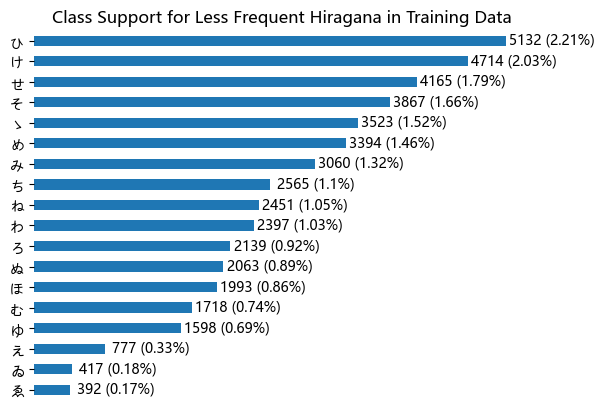

In [203]:
# Create plot
ax = filtered.plot(kind='barh')
plt.title('Class Support for Less Frequent Hiragana in Training Data')

# Get bars
rects = ax.patches

# Create labels
labels = filtered.apply(lambda x: f'{x} ({np.round(x/X_train.shape[0]*100.0, 2)}%)')

# Iterate over bars and add annotation
for i in range(0, len(rects)):
    ax.text(rects[i].get_width() + 500, rects[i].get_y() - 0.1, labels[i], ha="center", va="bottom")

# Remove borders / x-axis (unneeded)
plt.box(False)
ax.get_xaxis().set_visible(False)
    
# Display final result    
plt.show()

We can see that some hiragana represent less than 1% of observations, and the couple the are most infrequently represented, [ゑ (We)](https://en.wikipedia.org/wiki/We_(kana)) and [ゐ (Wi)](https://en.wikipedia.org/wiki/Wi_(kana)) have less than 0.2%, which makes sense [as they are considered to be obselete](https://www.japancentric.com/why-the-hiragana-for-wi-we-wu-yi-and-ye-arent-used/). We also see [ゆ (Yu)](https://en.wikipedia.org/wiki/Yu_(kana)) near the bottom, which is also considered obsolete or nearly so, according to the web, but for the remainder, I don't believe there is anything special about them, however it may be due to their frequency of occurence as well.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.nn import relu